## Questions:
- how have my top ranked artists changed over time?
- is my seasonal "rigidity" consistent over the years?
- is my heart rate correlated to genre?

In [2]:
import pandas as pd
import json
from parse_json import test_func
import os
from pyarrow import feather
import plotly.express as px
import plotly.graph_objects as go
from plotnine import *
import bokeh 
import numpy as np
os.chdir('/Users/christiantapp/Library/Mobile Documents/com~apple~CloudDocs/code/spotify')

### Data Prep

In [3]:
#process json into master frame
# master_frame = pd.DataFrame()
# for file in os.listdir('data/extended_streaming_history'):
#     if file.startswith('Streaming_History_Audio') and file.endswith('.json'):
#         master_frame = pd.concat([master_frame,pd.read_json('data/extended_streaming_history/' + file)])
# master_frame = master_frame.sort_values('ts').reset_index(drop=True)
# master_frame.to_csv('data/master_streaming_history.csv',index=False)

In [4]:
def date_to_szn(datetime):
    szn_dict = {'spring':[3,4,5], 'summer':[6,7,8], 'fall':[9,10,11], 'winter':[12,1,2]}
    month = datetime.month
    for szn in szn_dict:
        if month in szn_dict[szn]:
            return szn

In [5]:
master_frame = pd.read_csv('data/master_streaming_history.csv')
master_frame.ts = pd.to_datetime(master_frame.ts).dt.tz_convert('America/New_York')
master_frame['season'] = master_frame.ts.apply(date_to_szn)
master_frame['year'] = master_frame.ts.apply(lambda x: x.year)
master_frame['seconds_played'] = master_frame.ms_played / 1000
master_frame.columns

Index(['ts', 'platform', 'ms_played', 'conn_country', 'ip_addr',
       'master_metadata_track_name', 'master_metadata_album_artist_name',
       'master_metadata_album_album_name', 'spotify_track_uri', 'episode_name',
       'episode_show_name', 'spotify_episode_uri', 'audiobook_title',
       'audiobook_uri', 'audiobook_chapter_uri', 'audiobook_chapter_title',
       'reason_start', 'reason_end', 'shuffle', 'skipped', 'offline',
       'offline_timestamp', 'incognito_mode', 'season', 'year',
       'seconds_played'],
      dtype='object')

In [6]:
master_frame = master_frame.rename(columns = {
    'master_metadata_track_name':'track_name',
    'master_metadata_album_artist_name':'artist_name',
    'master_metadata_album_album_name':'album_name'})

## Top Ranked Artists

In [7]:
top_artists_per_year = (
    master_frame.groupby(['year','artist_name'])
    .seconds_played.sum()
    .reset_index(name='total_seconds_listened_to')
    .sort_values(by='total_seconds_listened_to', ascending=False)
    .groupby(['year'])
    .head(5)
    .sort_values(['year','total_seconds_listened_to'], ascending=False)
    .reset_index(drop=True)
)

top_artists_per_year['rank'] = (
    top_artists_per_year.groupby('year')['total_seconds_listened_to']
    .rank(method='dense', ascending=False)
    .astype(int)
)
#label column only for latest year the artist is present
top_artists_per_year['is_latest'] = top_artists_per_year['year'] == top_artists_per_year.groupby('artist_name')['year'].transform('max')
top_artists_per_year['label'] = top_artists_per_year.apply(
    lambda row: row['artist_name'] if row['is_latest'] else '',
    axis=1
)
top_artists_per_year.head()
top_artists_per_year.to_csv('data/processed/top_artists_per_year.csv',index=False)

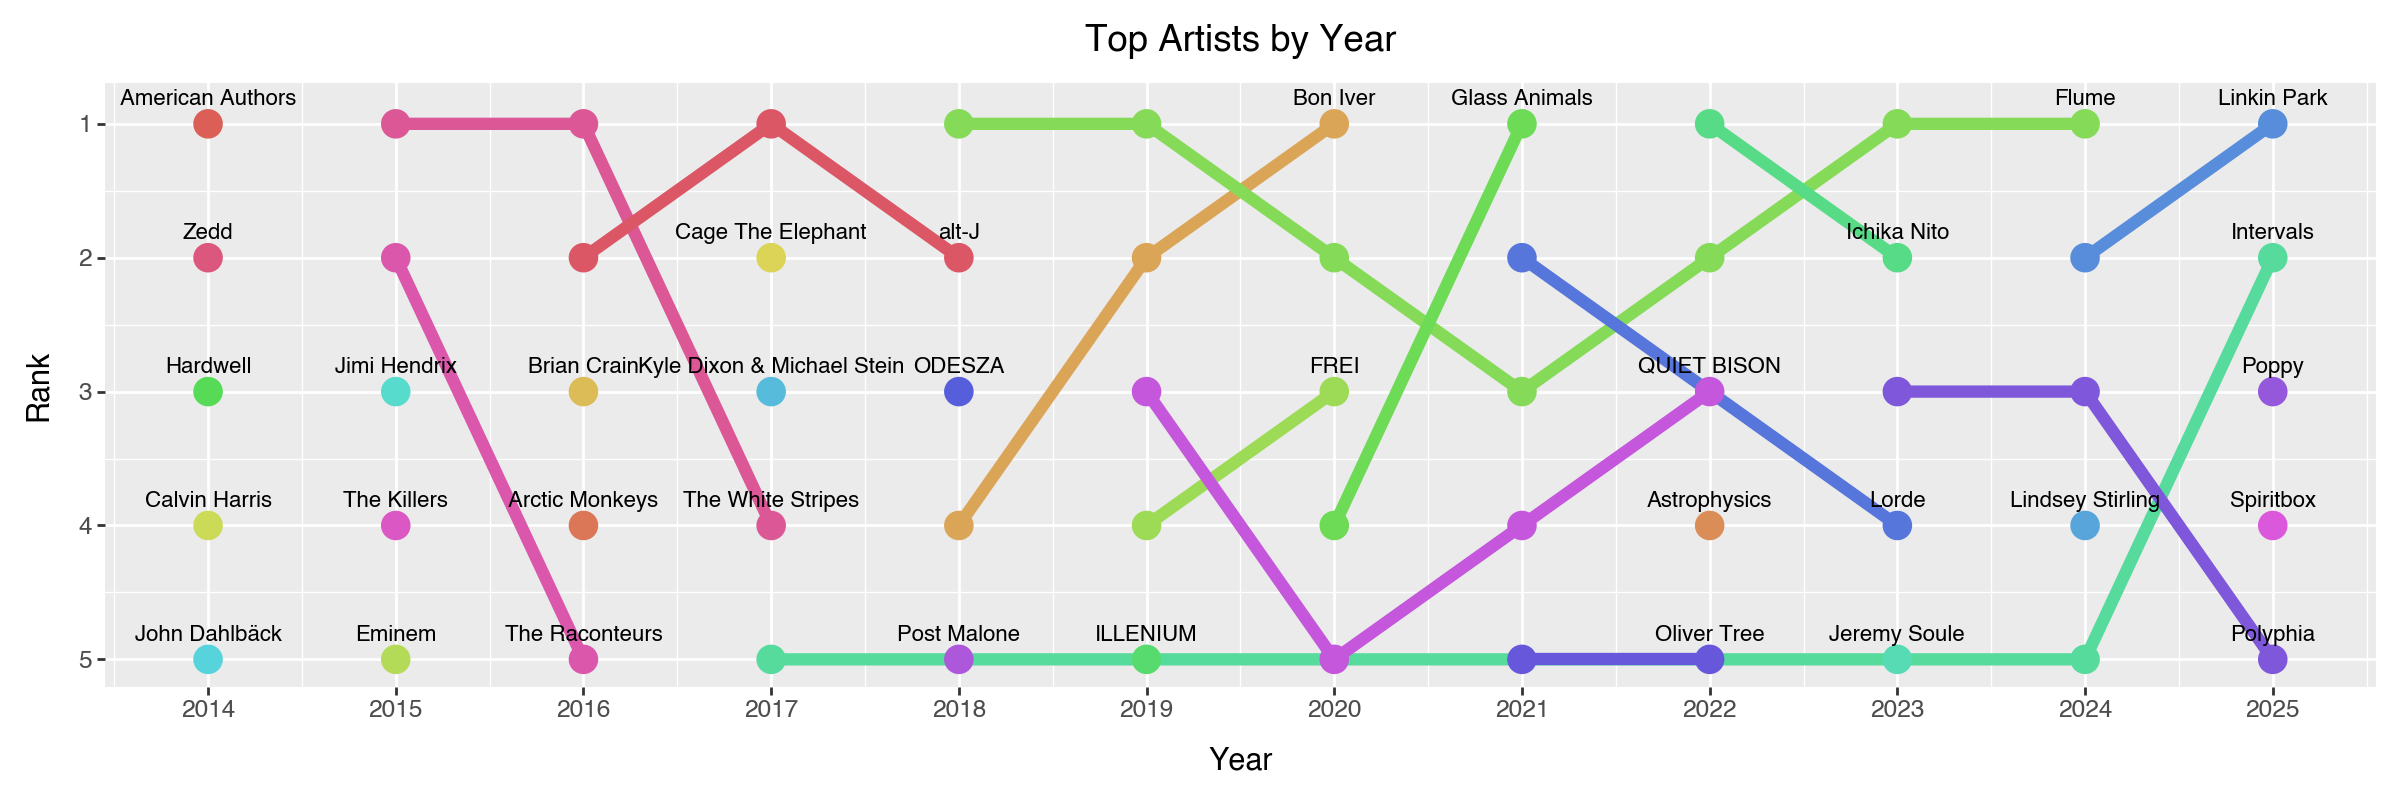

In [8]:
p = (
    ggplot(top_artists_per_year.query("year >= 2014"))
    + aes(x='year', y='rank', group='artist_name', color='artist_name')
    + geom_line(size=2.5)
    + geom_point(size=5)
    + geom_text(aes(label='label'), va='bottom', size=8, nudge_y=0.1, color = 'black')  # adjust size to match aesthetics
    + scale_y_reverse()
    + labs(
        title='Top Artists by Year',
        x='Year',
        y='Rank'
    )
    + scale_x_continuous(breaks=top_artists_per_year.year.unique())
    + theme(
        legend_position='none',
        figure_size=(12, 4),)
)

p

## Top Ranked Songs

In [9]:
top_tracks_by_season = (
    master_frame.groupby(['season','artist_name', 'track_name'])
    .seconds_played.sum()
    .reset_index(name='total_seconds_listened_to')
    .sort_values(by='total_seconds_listened_to', ascending=False)
    .groupby(['season'])
    .head(5)
    .sort_values(['season','total_seconds_listened_to'], ascending=False)
)
top_tracks_by_year = (
    master_frame.groupby(['year','artist_name', 'track_name'])
    .seconds_played.sum()
    .reset_index(name='total_seconds_listened_to')
    .sort_values(by='total_seconds_listened_to', ascending=False)
    .groupby(['year'])
    .head(5)
    .sort_values(['year','total_seconds_listened_to'], ascending=False)
)


## Seasonal Rigidity

In [10]:
master_frame.columns

Index(['ts', 'platform', 'ms_played', 'conn_country', 'ip_addr', 'track_name',
       'artist_name', 'album_name', 'spotify_track_uri', 'episode_name',
       'episode_show_name', 'spotify_episode_uri', 'audiobook_title',
       'audiobook_uri', 'audiobook_chapter_uri', 'audiobook_chapter_title',
       'reason_start', 'reason_end', 'shuffle', 'skipped', 'offline',
       'offline_timestamp', 'incognito_mode', 'season', 'year',
       'seconds_played'],
      dtype='object')

In [11]:
master_frame.head()

,ts,platform,ms_played,conn_country,ip_addr,track_name,artist_name,album_name,spotify_track_uri,episode_name,...,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode,season,year,seconds_played
0,2014-05-16 10:48:48-04:00,"iOS 7.1.1 (iPhone4,1)",13374,US,96.242.179.55,Countdown - Original Mix,Hardwell,Countdown,spotify:track:4yQpMgnJSWXdjrZr8B8XZz,NaN,...,NaN,fwdbtn,False,True,False,NaN,False,spring,2014,13.374
1,2014-05-16 10:48:50-04:00,"iOS 7.1.1 (iPhone4,1)",11563,US,96.242.179.55,Blink Again - Radio Edit,John Dahlbäck,Blink Again,spotify:track:1L6ZjM6aj7pGGjgHVSdSPd,NaN,...,fwdbtn,fwdbtn,True,True,False,NaN,False,spring,2014,11.563
2,2014-05-16 10:48:51-04:00,"iOS 7.1.1 (iPhone4,1)",10913,US,96.242.179.55,Beautiful People (Zamli Summer Remix),Benny Benassi,Benny Benassi ft. Chris Brown VS Zamli,spotify:track:252S4mCX2la1fsZFHQhEit,NaN,...,fwdbtn,fwdbtn,True,True,False,NaN,False,spring,2014,10.913
3,2014-05-16 10:48:54-04:00,"iOS 7.1.1 (iPhone4,1)",11656,US,96.242.179.55,Summer,Calvin Harris,Summer,spotify:track:7b71WsDLb8gG0cSyDTFAEW,NaN,...,fwdbtn,fwdbtn,True,True,False,NaN,False,spring,2014,11.656
4,2014-05-16 10:48:55-04:00,"iOS 7.1.1 (iPhone4,1)",10774,US,96.242.179.55,My Love,Route 94,My Love,spotify:track:2iS2s9oYpEmUzrAHPmqBHy,NaN,...,fwdbtn,fwdbtn,True,True,False,NaN,False,spring,2014,10.774


In [12]:

def shannon_entropy(probs):
    # Avoid log2(0) by filtering out zero probabilities
    probs = probs[probs > 0]
    return -np.sum(probs * np.log2(probs))

seasonal_totals = (
    master_frame.groupby(['artist_name', 'year', 'season'])['seconds_played']
    .sum()
    .reset_index(name='seasonal_total_seconds_played')
)
seasonal_totals['total_seconds_played_by_artist_year'] = (
    seasonal_totals.groupby(['artist_name', 'year'])['seasonal_total_seconds_played'].transform('sum')
)
seasonal_totals['season_prop'] = (
    seasonal_totals['seasonal_total_seconds_played'] / seasonal_totals['total_seconds_played_by_artist_year']
)

#ranking artists on listen time
artist_totals = (
    seasonal_totals.groupby('artist_name')['seasonal_total_seconds_played']
    .sum()
    .reset_index(name='total_seconds_played_all_years')
)
artist_totals['artist_rank_by_listen_time'] = artist_totals['total_seconds_played_all_years'].rank(method='dense',ascending=False).astype(int)

seasonal_totals = seasonal_totals.merge(
    artist_totals[['artist_name', 'artist_rank_by_listen_time']],
    on='artist_name',
    how='left'
)


# calc entropy
entropy_df = (
    seasonal_totals.groupby(['artist_name', 'year'])['season_prop']
    .apply(lambda x: shannon_entropy(x.values))
    .reset_index(name='seasonal_entropy_per_year')
)
seasonal_totals = seasonal_totals.merge(
    entropy_df,
    on=['artist_name', 'year'],
    how='left'
)

seasonal_artists = seasonal_totals.sort_values(
    by=['seasonal_entropy_per_year'],
    ascending=False
)
seasonal_artists

,artist_name,year,season,seasonal_total_seconds_played,total_seconds_played_by_artist_year,season_prop,artist_rank_by_listen_time,seasonal_entropy_per_year
4181,Hans Hu$tle,2023,summer,127.568,527.138,0.242001,1104,1.989015
4179,Hans Hu$tle,2023,fall,123.839,527.138,0.234927,1104,1.989015
4180,Hans Hu$tle,2023,spring,159.549,527.138,0.302670,1104,1.989015
4182,Hans Hu$tle,2023,winter,116.182,527.138,0.220401,1104,1.989015
6838,Mapei,2018,spring,541.267,2370.340,0.228350,329,1.955444
...,...,...,...,...,...,...,...,...
5549,Katy Perry,2020,winter,182.520,182.520,1.000000,2781,-0.000000
5550,Katy Perry,2024,spring,8.812,8.812,1.000000,2781,-0.000000
5551,Kavinsky,2015,summer,18.854,18.854,1.000000,617,-0.000000
5552,Kavinsky,2019,spring,6.524,6.524,1.000000,617,-0.000000


In [13]:
top_10_artists = seasonal_artists.query('artist_rank_by_listen_time <= 10').sort_values(by = ['year','artist_name']).reset_index(drop=True)
top_10_artists

,artist_name,year,season,seasonal_total_seconds_played,total_seconds_played_by_artist_year,season_prop,artist_rank_by_listen_time,seasonal_entropy_per_year
0,Arctic Monkeys,2015,summer,949.467,1706.362,0.556428,9,1.347064
1,Arctic Monkeys,2015,fall,571.489,1706.362,0.334917,9,1.347064
2,Arctic Monkeys,2015,winter,185.406,1706.362,0.108656,9,1.347064
3,Linkin Park,2015,winter,1128.287,1734.435,0.650521,5,1.029999
4,Linkin Park,2015,fall,13.336,1734.435,0.007689,5,1.029999
...,...,...,...,...,...,...,...,...
270,Ichika Nito,2025,spring,279.850,288.418,0.970293,4,0.192920
271,Ichika Nito,2025,winter,8.568,288.418,0.029707,4,0.192920
272,Linkin Park,2025,spring,12220.505,41015.277,0.297950,5,0.878771
273,Linkin Park,2025,winter,28794.772,41015.277,0.702050,5,0.878771


## Heart Rate Influences Genre?

In [14]:
all_heart_rate = pd.read_feather('/Users/christiantapp/Library/Mobile Documents/com~apple~CloudDocs/code/apple-heart-rate/data/heart_rate.feather')
all_heart_rate.head()
heart_rate = all_heart_rate[['startDate','value','moon_phase','measurement_gap','inferred_sleep']].copy()
heart_rate.startDate = pd.to_datetime(heart_rate['startDate']).dt.tz_localize('America/New_York', nonexistent= 'shift_forward', ambiguous= True)

In [15]:
hr_songs = pd.merge_asof(
                         master_frame.sort_values('ts'),
                         heart_rate.sort_values('startDate'), 
                         left_on='ts', right_on='startDate', direction='nearest'
                         )
hr_songs = hr_songs.rename(columns={'value': 'heart_rate', 'startDate': 'hr_start_date'})

hr_songs.ms_played = pd.to_timedelta(hr_songs['ms_played'], unit='ms')

#filtering to rows where heart rate measurement occurs during song
hr_songs = hr_songs[
    (hr_songs['hr_start_date'] >= hr_songs['ts']) &
    (hr_songs['hr_start_date'] <= hr_songs['ts'] + hr_songs['ms_played'])
]
hr_songs = hr_songs.sort_values('hr_start_date').reset_index(drop=True)
hr_songs['hr_bins'] = pd.cut(hr_songs['heart_rate'], [0,65,85,120,160,210], labels=['resting','chilling','walking','exercising','going_feral'])

hr_bin_order = ['resting', 'chilling', 'walking', 'exercising', 'going_feral']

hr_songs['hr_bins'] = pd.Categorical(
    hr_songs['hr_bins'],
    categories=hr_bin_order,
    ordered=True
)

In [16]:
# top artists in each hr bin, vs what hr bin i most frequently listen to a given artist in?
top_artists_hr_bins = (
    hr_songs.groupby(['hr_bins', 'artist_name'])
    .size()
    .reset_index(name = 'num_times_listened')
    .sort_values(['hr_bins', 'num_times_listened'], ascending=[True, False])
    .groupby('hr_bins')
    .head(5)
    .reset_index(drop=True)
)
top_artists_hr_bins

/var/folders/jq/nlt5smyd2n3d16lslnyb4zyw0000gn/T/ipykernel_24228/2091120869.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/jq/nlt5smyd2n3d16lslnyb4zyw0000gn/T/ipykernel_24228/2091120869.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,hr_bins,artist_name,num_times_listened
0,resting,Flume,410
1,resting,Ichika Nito,272
2,resting,alt-J,206
3,resting,Bon Iver,147
4,resting,Polyphia,105
5,chilling,Flume,1176
6,chilling,Ichika Nito,359
7,chilling,Bon Iver,319
8,chilling,alt-J,282
9,chilling,QUIET BISON,234
